<a href="https://colab.research.google.com/github/Mark-G321/SVM_w_SMO_analysis.ipynb/blob/main/SVM_w_SMO_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code creates an SVM implementation where the fit method is implemented using the SMO technique as described in the article: "Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines" by John C. Platt.

The training of a support vector machine requires the solution of
a very large quadratic programming (QP) optimization problem. SMO breaks this large
QP problem into a series of the smallest possible QP problems. These small QP problems are
solved analytically, which avoids using a time-consuming numerical QP optimizations.

The strategy for picking up the multipliers to optimize I used is based on the strategy proposed in the article: picking the parameters in an hierarchical manner, first we would prefer non bounded alpha before going through them all and as for the second alpha we would prefer ones that have non zero error and provide the maximal absolute value error.

For the convergence criterion I used both a certain tolerance that would check if the alpha are close enough to optimal and the max number of iteration to stop

The threshold b is being computed using the update rule proposed in the article under 2.3 such that the KKT condition will hold each iteration.

To run the code all that is needed is to create the model using the SVM class, then to train it using the fit method passing the data and labels to it.

In another cell I added some dummy data(the data is 2d for the purposes of graphing it) the model is trained on the data and then an accuracy metric is given together with a graph including the data separated by color and the separator line found by the svm


Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

Create an SVM class with a fit function that trains it using the SMO technique described in the article "Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines".

In [ ]:
class SVM: 
    def __init__(self, C=1.0, tol=1e-3, max_iter=100, Kernel='linear', gamma = 1.0):
      self.C = C # constant C in the objective function(determing the "punishment" for not perfect seperation)
      self.tol = tol # tolerance for stopping criterion
      self.max_iter = max_iter # maximum number of iterations allowed before stopping
      self.w = [] # weight vector
      self.b = 0 # bias term
      self.kernel= self._linear_kernel if Kernel=='linear' else self._rbf_kernel # uses as default the linear kernel
      self.kernel_type = 'linear' if Kernel == 'linear' else 'RBF'
      self.gamma = gamma  # gamma parameter for the rbf function
    
    def _compute_bounds(self, i1, i2, y1, y2):
      # Computes L, H via equations (13) and (14) in the article
      if y1 == y2:
          L = max(0, self.alpha[i1] + self.alpha[i2] - self.C)
          H = min(self.C, self.alpha[i1] + self.alpha[i2])
      else:
          L = max(0, self.alpha[i2] - self.alpha[i1])
          H = min(self.C, self.C + self.alpha[i2] - self.alpha[i1])
      return L, H
    
    def _compute_Lobj_Hobj(self, L, H, i1, i2,k11,k22,k12):
      # Computes the Lobj and Hobj using the rule in the article (used when using a kernel that doesnt obey Mercer’s condition)
      a1, a2 = self.alpha[i1], self.alpha[i2]
      y1, y2=self.y[i1],self.y[i2]
      E1, E2 = self.E[i1] , self.E[i2]
      eta =  k11 + k22 - 2 * k12
      if L == H:
          Lobj = Hobj = 0.5 * (a1 * a1 * k11 + a2 * a2 * k22 + 2 * a1 * a2 * k12) - a1 * y1 * E1 - a2 * y2 * E2
      else:
          Lobj = 0.5 * (L * L * k11 + a2 * a2 * k22 + 2 * L * a2 * k12) - L * y1 * E1 - a2 * y2 * E2
          Hobj = 0.5 * (H * H * k11 + a2 * a2 * k22 + 2 * H * a2 * k12) - H * y1 * E1 - a2 * y2 * E2
      return Lobj, Hobj
    
    def _take_step(self, i1, i2):
      if i1 == i2:
          return 0
      alph1, y1 = self.alpha[i1], self.y[i1]
      E1 = self.E[i1]
      s = y1 * self.y[i2]
      #compute the bounds:
      L, H = self._compute_bounds(i1, i2, y1, self.y[i2])
      if L == H:
          return 0
      #compute eta:
      k11 = self.kernel(self.X[i1], self.X[i1])
      k12 = self.kernel(self.X[i1], self.X[i2])
      k22 = self.kernel(self.X[i2], self.X[i2])
      eta = k11 + k22 - 2 * k12
      #save the old alpha2
      alph2=self.alpha[i2]
      E2 = self.E[i2]
      eps = 1e-5 # This value found to give best results for the puprose of testing later
      if eta > 0: 
        self.alpha[i2] += self.y[i2] * (E1 - E2) / eta #updates using the derived update rule in question 10
        #clipping:
        self.alpha[i2] = max(self.alpha[i2], L) 
        self.alpha[i2] = min(self.alpha[i2], H)
      else:
        #based on the code in the article:
        Lobj, Hobj=self._compute_Lobj_Hobj(L, H, i1, i2,k11,k22,k12)
        if Lobj<Hobj-1e-5:
          self.alpha[i2]=L
        elif Lobj>Hobj+1e-5:
          self.alpha[i2]=H
        else:
          self.alpha[i2]=alph2
      if abs(self.alpha[i2] - alph2) < eps*(self.alpha[i2]+alph2+eps): # Tests whether the change in alph2 is meaningfull enough
          return 0
      self.alpha[i1] += s * (alph2 - self.alpha[i2]) #updates alph1 based the the update rule in question 10
      self._update_bias(i1, i2, alph1, alph2) #updates the bias based on rule given in the article
      self.w += (y1 * (self.alpha[i1]-alph1)) * self.X[i1] + (self.y[i2] * (self.alpha[i2]-alph2)) * self.X[i2] # Updates the weights based on the rule in the article
      # Updates the error cache for the new alpha
      self.E[i1]=self._compute_E(i1)
      self.E[i2]=self._compute_E(i2)
      #checks if the new alpha are bounded or not and adds them to non_bound_alpha
      if 0<self.alpha[i1]<self.C:
        self.non_bound_alpha[i1]=self.alpha[i1]
      else:
        self.non_bound_alpha[i1]=0
      if 0<self.alpha[i2]<self.C:
        self.non_bound_alpha[i2]=self.alpha[i2]
      else:
        self.non_bound_alpha[i2]=0
      return 1
    
    def _update_bias(self, i1, i2, alph1, alph2):
      #updates the bias based on the rule in the article:
      y1, y2 = self.y[i1] , self.y[i2]
      E1, E2 = self.E[i1] , self.E[i2]
      b1 = self.b - E1 - y1 * (self.alpha[i1] - alph1) * self.kernel(self.X[i1], self.X[i1]) - y2 * (self.alpha[i2] - alph2) * self.kernel(self.X[i1], self.X[i2])
      b2 = self.b - E2 - y1 * (self.alpha[i1] - alph1) * self.kernel(self.X[i1], self.X[i2]) - y2 * (self.alpha[i2] - alph2) * self.kernel(self.X[i2], self.X[i2])
      if 0 < self.alpha[i1] < self.C:
          self.b = b1
      elif 0 < self.alpha[i2] < self.C:
          self.b = b2
      else:
          self.b = (b1 + b2) / 2
    
    def _compute_E(self, i):
      # Computes the error of sample i
      #return np.dot(self.X[i],self.w)+self.b - self.y[i]
      return self.predict(X[i]) - self.y[i]
    
    def _second_choice_heuristic(self,i2):
      # Check for non-zero error that is not alph2 Based on the heuristic in the article
      nonzero_E = np.nonzero(self.E)[0] #gets the indices of all the nonezero elements in E
      nonzero_not_alph2 = nonzero_E[nonzero_E != i2] #remove the index of alph2 from the list
      if len(nonzero_not_alph2) > 0:
          return nonzero_not_alph2[0] #return the first one 
      
      # Select alpha with maximum absolute error
      i1 = np.argmax(np.abs(self.E))
      return i1

    def _examine_example(self, i2):
      y2 = self.y[i2]
      alph2 = self.alpha[i2]
      E2 = self.E[i2]
      r2 = E2 * y2
      if ((r2 < -self.tol and alph2 < self.C) or (r2 > self.tol and alph2 > 0)):
          if sum(self.non_bound_alpha)>0: # If number of non-zero & non-C alpha > 1 
              i1 = self._second_choice_heuristic(i2)
              if self._take_step(i1, i2):
                  return 1
          for i1 in range(len(self.non_bound_alpha)):
              if self.non_bound_alpha[i1] ==0: continue
              if self._take_step(i1, i2):
                  return 1
          for i1 in range(self.n):
              if self._take_step(i1, i2):
                  return 1
      return 0
    
    def fit(self, X, y):
      #trains the SVM on data X with labels y using the SMO algorithm
      # Initilization of parameters:
      self.X = X
      self.y = y
      self.n = len(y)
      self.d = len(X[0])
      self.alpha = np.zeros(self.n) #multipliers
      self.w= np.zeros(self.d)
      self.b = 0
      self.E = [-y[i] for i in range(self.n)]
      self.non_bound_alpha = np.zeros(self.n)
      num_changed = 0
      examine_all = 1
      iter_ = 0
      while (num_changed > 0 or examine_all) and iter_ < self.max_iter:
          num_changed = 0
          if examine_all:
              for i2 in range(self.n):
                  num_changed += self._examine_example(i2)
          else:
              for i2 in range(len(self.non_bound_alpha)):
                  if self.non_bound_alpha[i2]==0: continue
                  num_changed += self._examine_example(i2)
          if examine_all == 1:
              examine_all = 0
          elif num_changed == 0:
              examine_all = 1
          iter_ += 1

    
    def predict(self, x):
      # Predicts on input x
      if self.kernel_type == 'linear':
        return np.sign(np.dot(x,self.w) + self.b,casting = 'unsafe',dtype=int)
      else:
        t=self.b
        # Sums over a_i*y_i*k(x_i,x)
        for i in range(len(self.y)):
          t+=self.alpha[i] * self.y[i] * self._rbf_kernel(self.X[i], x) 
        return np.sign(t,casting = 'unsafe',dtype=int)
    
    def _linear_kernel(self, x1, x2):
      # Linear Kernel
      return np.dot(x1, x2)

    def _rbf_kernel(self, x1, x2):
      # RBF kernel
      return np.exp(-self.gamma * (np.linalg.norm(x1 - x2) ** 2))



Generates data and trains the SVM on it, then prints the accuracy on the data and plots the training set and the linear separator found by the SMO .

The weights vector w is: [ 12.66946578 -12.63228531] And the bias is: -2.576519034837326
Accuracy: 0.995


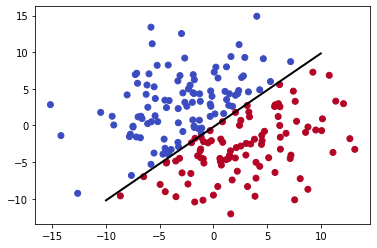

In [ ]:
# Generate some random 2D data
X = np.random.randn(200, 2)
X = X * 5 # Increase the data spread for the graphing later
y = np.array([1 if x[0] > x[1] else -1 for x in X]) # Label them linearly


# Create and Train the SVM model
# Define hyper parameters:
C=1
tol=1e-3
max_iter=100
# Create the model using given parameters:
svm = SVM(C, tol, max_iter)
svm.fit(X, y)
print("The weights vector w is:", svm.w, "And the bias is:", svm.b) # Printing the weights and bias for testing purposes

# Evaluate the model after training on the training set(ideally a validation set would be used here)
predictions = svm.predict(X) 
accuracy = np.mean(predictions == y)
print("Accuracy:", accuracy)

# Plot the training data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm")

# Plot the decision boundary
w = svm.w
b = svm.b
xx = np.linspace(-10, 10)
yy = -w[0]/w[1] * xx - b/w[1] # Finds the linear function defined by w and b based on a known equation.
plt.plot(xx, yy, c="k", linewidth=2)
plt.show()

Lets test our models implementation using the Iris dataset.
First lets load the data and plot it, just to see how it behaves.

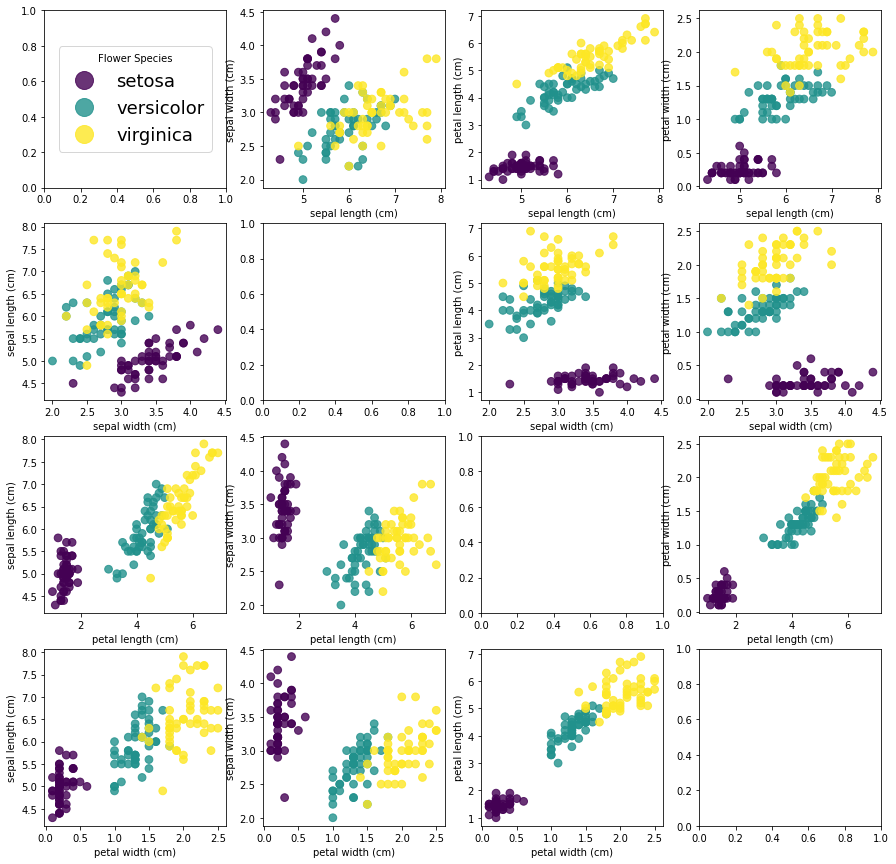

In [ ]:
# Load the Iris dataset
iris = datasets.load_iris()

# Extract the features and labels from the dataset
X = iris.data
y = iris.target

# Get the names of the features and the target names (the flower name)
feature_names = iris.feature_names
target_names = iris.target_names

# Create a grid of subplots
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Plot the data in each subplot
for i in range(4):
    for j in range(4):
        # Skip the case that i=j since it will plot the feature against itself
        if i==j: continue
        # Plot the data in the i-th column against the data in the j-th column
        scatter = axs[i, j].scatter(X[:, i], X[:, j], c=y, s=60, alpha=.8)
        # Set the axis labels
        axs[i, j].set_xlabel(feature_names[i])
        axs[i, j].set_ylabel(feature_names[j])

# Create a legend using matplotlib's legend function
legend = axs[0, 0].legend(*scatter.legend_elements(), title="Flower Species", prop={'size': 18}, loc='center', markerscale=3)

# Set the labels of the legend to the flower names
for i in range(len(target_names)):
  legend.get_texts()[i].set_text(target_names[i])

plt.show()


As we could see from the scatter plot matrix, the purple dots which represent the Setosa flower seem to be the most separable.

Now lets use the "train_test_split" function from the sklrean library to split the data according to the "rule of thumb" that is into 60% training, 20% validation, and 20% testing.

In [ ]:
# Split the data into training and test sets where 60% is the training set
X_train,X_test, y_train, y_test=train_test_split(X, y, test_size=0.4, random_state=3) 

# Split the test set into test and validation sets both will be 20% of the original size
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=3)


Now lets create and train our SVM models on each of the flower classes each time selecting the C that best fits that model, basing our C selection on the accuracy result on the validation set.

In [ ]:
# Create a multiclass svm
multiclass_svm=[]

# Train SVM for each class
for i in range(3):
  # Create a binary label set for this class (the label will be 1 if its the i-th flower, else -1)
  y_binary_train = np.where(y_train == i, 1, -1)
  y_binary_val = np.where(y_val == i, 1, -1)

  # Train the SVM corresponding to the current flower
  best_C = 0
  best_accuracy = 0
  for cur_c in [0.01, 0.1, 1, 10, 100]:
    svm = SVM(C=cur_c)
    # Train on current C
    svm.fit(X_train, y_binary_train)
    # Use the validation set to test the accuracy with current C
    predictions = svm.predict(X_val) 
    accuracy = np.mean(predictions == y_binary_val)
    # Updates the best C
    if accuracy > best_accuracy:
      best_C = cur_c
      best_accuracy = accuracy
        
  # Retrain the SVM with the best C on the full training set(not including the test set)
  svm = SVM(C=best_C)
  X_full = np.concatenate((X_train, X_val), axis=0)
  y_full = np.concatenate((y_train, y_val), axis=0)
  y_binary_full = np.where(y_full == i, 1, -1)
  svm.fit(X_full, y_binary_full)
  
  #add the svm into the multiclass_svm
  multiclass_svm.append(svm)

Now lets use the test set to get predictions and show their accuracy.
Then we will plot the corresponding confusion matrix.

In [ ]:
# Calculate the accuracy of multiclass svm 
for svm in multiclass_svm:
  # Evaluate the SVM on the test set
  i = multiclass_svm.index(svm)
  y_binary_test = np.where(y_test == i, 1, -1)
  predictions = svm.predict(X_test) 
  accuracy = np.mean(predictions == y_binary_test)  
  print(f'Test accuracy for class {target_names[i]}: {accuracy} with C chosen to be: {svm.C}')

Test accuracy for class setosa: 1.0 with C chosen to be: 1
Test accuracy for class versicolor: 0.7666666666666667 with C chosen to be: 0.1
Test accuracy for class virginica: 0.6666666666666666 with C chosen to be: 0.1


Now lets run our multiclass svm on all the test samples, catagorizing them based on each models confidence in its prediction (measured as max(wx+b))

In [ ]:
# Save the confidence (wx+b) of all the svm's in the multiclass_svm
confidence = []
for svm in multiclass_svm:
  confidence.append(np.dot(X_test, svm.w)+svm.b)

# Select the label the multiclass svm was the most confident in
predictions = np.argmax(confidence,axis=0)
# calculate the accuracy of the multiclass model
result = sum([1 if predictions[i]==y_test[i] else 0 for i in range(len(predictions))])
print(f'Correctly catagorized: {result}/{len(y_test)} samples thus the acccuracy of the multiclass model is {round(result/len(y_test)*100,2)}%')


Correctly catagorized: 22/30 samples thus the acccuracy of the multiclass model is 73.33%


Finally lets create a confusion matrix of the data:

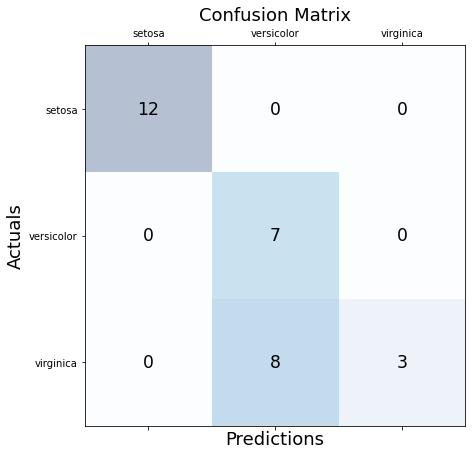

In [ ]:
from sklearn.metrics import confusion_matrix
# Create a confusion matrix based on the models predictions
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)


#create a subplot for the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the confusion matrix using matshow
ax.matshow(conf_matrix, cmap="Blues", alpha=0.3)

# Set the x-axis and y-axis tick locations and labels
ax.set_xticks(np.arange(len(target_names)))
ax.set_xticklabels(target_names)
ax.set_yticks(np.arange(len(target_names)))
ax.set_yticklabels(target_names)
# Iterate through each cell in the confusion matrix and add the value to the plot
for i in range(conf_matrix.shape[0]):
  for j in range(conf_matrix.shape[1]):
    ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# Add labels and title to the plot
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

We can see from the confusion matrix that our multiclass model has no problem classifying the separable class of 'Setosa' correctly, but has trouble correctly classifiying the two other classes that is 'Versicolor' and 'Viriginica'. This is of course due to the fact that they are less separable using linear means

Now lets plot the table of confusion

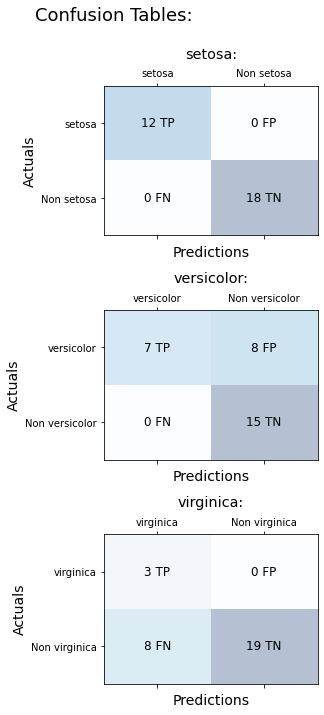

In [ ]:
# For each flower count the number of TP,TN,FP,FN and add to a table
table = []
for i in range(3):
  true_positives = conf_matrix[i, i]
  false_positives = sum(conf_matrix[:, i]) - true_positives
  false_negatives = sum(conf_matrix[i]) - true_positives
  true_negatives = len(predictions) - (true_positives + false_positives + false_negatives)
  table.append([target_names[i], true_positives, false_positives, false_negatives, true_negatives])
# Create the correspoinding labels
labels =[" TP", " FP", " FN", " TN"]
labels = np.reshape(labels,(2,2))

#create a subplot for each of the confusion tables
fig, axs = plt.subplots(3, 1, figsize=(20, 11), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
fig.suptitle("Confusion Tables:", ha="right", fontsize=18)

# Plot the tables of confusion using matshow
for i in range(3):
  # Arrange the data
  table_data = np.reshape(table[i][1:], (2, 2))
  axs[i].matshow(table_data, cmap="Blues", alpha=0.3)
  
  # Set the title x-axis and y-axis tick locations and labels
  axs[i].set_title(table[i][0] + ":", pad=20,size='x-large')
  axs[i].set_xticks(np.arange(2))
  axs[i].set_xticklabels([table[i][0], "Non " + table[i][0]])
  axs[i].set_yticks(np.arange(2))
  axs[i].set_yticklabels([table[i][0], "Non " + table[i][0]])
  axs[i].set_xlabel('Predictions', fontsize=14,labelpad=10)
  axs[i].set_ylabel('Actuals', fontsize=14)
  axs[i].set_aspect(0.7)

  # Iterate through each cell in the confusion table and add the value to the plot
  for k in range(2):
    for j in range(2):
      axs[i].text(x=j, y=k,s=str(table_data[k][j]) + labels[k][j], va='center', ha='center', size='large')
  
plt.show()


Finally we can print the accuracy and sensitivity


In [ ]:
# Create a table to hold our measurments
measurements = []
for i in range(len(table)):
  TP, FP, FN, TN = table[i][1:]
  # Calculate the accuracy, sensitivity, and selectivity
  accuracy = (TP + TN) / (TP + FP + FN + TN)
  sensitivity = TP/(TP + FN)
  selectivity = TN/(TN + FP)
  # Save our measurments
  measurements.append([table[i][0], accuracy, sensitivity, selectivity])

for i in range(3):
  print(f'For the flower: {measurements[i][0].capitalize()} the acccuracy was {measurements[i][1]} the sensitivity was {measurements[i][2]} and the selectivity was {measurements[i][3]}')


For the flower: Setosa the acccuracy was 1.0 the sensitivity was 1.0 and the selectivity was 1.0
For the flower: Versicolor the acccuracy was 0.7333333333333333 the sensitivity was 1.0 and the selectivity was 0.6521739130434783
For the flower: Virginica the acccuracy was 0.7333333333333333 the sensitivity was 0.2727272727272727 and the selectivity was 1.0


As we can see from the result, since the test set was relativly small, we managed to achieve relativly high accuracy even for the non-seperable Versicolor and Virginica flowers of course we would expect the highest accuracy with the Setosa flower since it is the one most seperable from the three.
As for the sensitivity again with the seperable case of Setosa we had high sensitivity meaning we were able to confidently identify Setosa flowers, but with the Versicolor and Virginica flowers our sensitivty dropped again due to the fact the our model was more likly to confuse between Virginica and Versicolor.

For the last part we will use the RBF kernel to repeat everything we have done until now. (since the only change from before is the use of the rbf kernel I've allowed myself to put everything into the same block of code).

Test accuracy for class setosa: 0.6333333333333333 with C chosen to be: 1 and gamma 0.01
Test accuracy for class versicolor: 0.8333333333333334 with C chosen to be: 10 and gamma 1
Test accuracy for class virginica: 0.0 with C chosen to be: 100 and gamma 1
Correctly catagorized: 28/30 samples thus the acccuracy of the multiclass model is 93.33%


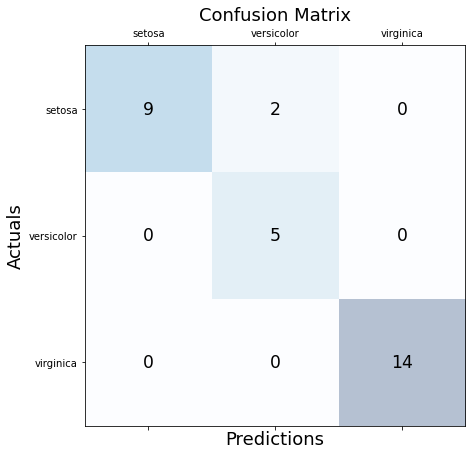

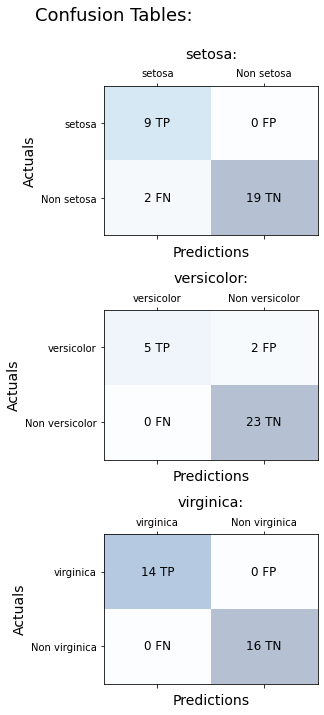

For the flower: Setosa the acccuracy was 0.9333333333333333 the sensitivity was 0.8181818181818182 and the selectivity was 1.0
For the flower: Versicolor the acccuracy was 0.9333333333333333 the sensitivity was 1.0 and the selectivity was 0.92
For the flower: Virginica the acccuracy was 1.0 the sensitivity was 1.0 and the selectivity was 1.0


In [ ]:
# Split the data into training and test sets where 60% is the training set
X_train,X_test, y_train, y_test=train_test_split(X, y, test_size=0.4, random_state=322) 

# Split the test set into test and validation sets both will be 20% of the original size
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=223)

# Create a multiclass svm
multiclass_svm=[]

# Train SVM for each class
for i in range(3):
  # Create a binary label set for this class (the label will be 1 if its the i-th flower, else -1)
  y_binary_train = np.where(y_train == i, 1, -1)
  y_binary_val = np.where(y_val == i, 1, -1)

  # Train the SVM corresponding to the current flower
  best_gamma = 0
  best_C = 0
  best_accuracy = 0
  for cur_c in [0.01, 0.1, 1, 10, 100]:
    for cur_gamma in [0.01, 0.1, 1, 10, 100]:
      svm = SVM(C=cur_c, Kernel= 'RBF', gamma= cur_gamma)
      # Train on current C
      svm.fit(X_train, y_binary_train)
      # Use the validation set to test the accuracy with current C
      predictions = [svm.predict(x) for x in X_val]
      accuracy = np.mean(predictions == y_binary_val)
      # Updates the best C
      if accuracy > best_accuracy:
        best_gamma = cur_gamma
        best_C = cur_c
        best_accuracy = accuracy
    
  # Retrain the SVM with the best C on the full training set(not including the test set)
  svm = SVM(C=best_C, Kernel='RBF', gamma= best_gamma)
  X_full = np.concatenate((X_train, X_val), axis=0)
  y_full = np.concatenate((y_train, y_val), axis=0)
  y_binary_full = np.where(y_full == i, 1, -1)
  svm.fit(X_full, y_binary_full)
  
  #add the svm into the multiclass_svm
  multiclass_svm.append(svm)

# Calculate the accuracy of multiclass svm 
for svm in multiclass_svm:
  # Evaluate the SVM on the test set
  i = multiclass_svm.index(svm)
  y_binary_test = np.where(y_test == i, 1, -1)
  predictions = svm.predict(X_test) 
  accuracy = np.mean(predictions == y_binary_test)  
  print(f'Test accuracy for class {target_names[i]}: {accuracy} with C chosen to be: {svm.C} and gamma {svm.gamma}')

# Save the confidence of all the svm's in the multiclass_svm
confidence = []
for svm in multiclass_svm:
  tmp = []
  # Sums over a_i*y_i*k(x_i,x)
  for x in X_test:
    t=svm.b
    for i in range(len(svm.y)):
      t+=svm.alpha[i] * svm.y[i] * (-svm.gamma *np.linalg.norm(svm.X[i]- x)**2)
    tmp.append(t)
  confidence.append(tmp)

# Select the label the multiclass svm was the most confident in
predictions = np.argmax(confidence,axis=0)
# calculate the accuracy of the multiclass model
result = sum([1 if predictions[i]==y_test[i] else 0 for i in range(len(predictions))])
print(f'Correctly catagorized: {result}/{len(y_test)} samples thus the acccuracy of the multiclass model is {round(result/len(y_test)*100,2)}%')


# Create a confusion matrix based on the models predictions
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

#create a subplot for the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))

# Plot the confusion matrix using matshow
ax.matshow(conf_matrix, cmap="Blues", alpha=0.3)

# Set the x-axis and y-axis tick locations and labels
ax.set_xticks(np.arange(len(target_names)))
ax.set_xticklabels(target_names)
ax.set_yticks(np.arange(len(target_names)))
ax.set_yticklabels(target_names)
# Iterate through each cell in the confusion matrix and add the value to the plot
for i in range(conf_matrix.shape[0]):
  for j in range(conf_matrix.shape[1]):
    ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# Add labels and title to the plot
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
# For each flower count the number of TP,TN,FP,FN and add to a table
table = []
for i in range(3):
  true_positives = conf_matrix[i, i]
  false_positives = sum(conf_matrix[:, i]) - true_positives
  false_negatives = sum(conf_matrix[i]) - true_positives
  true_negatives = len(predictions) - (true_positives + false_positives + false_negatives)
  table.append([target_names[i], true_positives, false_positives, false_negatives, true_negatives])
# Create the correspoinding labels
labels =[" TP", " FP", " FN", " TN"]
labels = np.reshape(labels,(2,2))

#create a subplot for each of the confusion tables
fig, axs = plt.subplots(3, 1, figsize=(20, 11), gridspec_kw={'wspace': 0.5, 'hspace': 0.5})
fig.suptitle("Confusion Tables:", ha="right", fontsize=18)

# Plot the tables of confusion using matshow
for i in range(3):
  # Arrange the data
  table_data = np.reshape(table[i][1:], (2, 2))
  axs[i].matshow(table_data, cmap="Blues", alpha=0.3)
  
  # Set the title x-axis and y-axis tick locations and labels
  axs[i].set_title(table[i][0] + ":", pad=20,size='x-large')
  axs[i].set_xticks(np.arange(2))
  axs[i].set_xticklabels([table[i][0], "Non " + table[i][0]])
  axs[i].set_yticks(np.arange(2))
  axs[i].set_yticklabels([table[i][0], "Non " + table[i][0]])
  axs[i].set_xlabel('Predictions', fontsize=14,labelpad=10)
  axs[i].set_ylabel('Actuals', fontsize=14)
  axs[i].set_aspect(0.7)

  # Iterate through each cell in the confusion table and add the value to the plot
  for k in range(2):
    for j in range(2):
      axs[i].text(x=j, y=k,s=str(table_data[k][j]) + labels[k][j], va='center', ha='center', size='large')
  
plt.show()
# Create a table to hold our measurments
measurements = []
for i in range(len(table)):
  TP, FP, FN, TN = table[i][1:]
  # Calculate the accuracy, sensitivity, and selectivity
  accuracy = (TP + TN) / (TP + FP + FN + TN)
  sensitivity = TP/(TP + FN)
  selectivity = TN/(TN + FP)
  # Save our measurments
  measurements.append([table[i][0], accuracy, sensitivity, selectivity])

for i in range(3):
  print(f'For the flower: {measurements[i][0].capitalize()} the acccuracy was {measurements[i][1]} the sensitivity was {measurements[i][2]} and the selectivity was {measurements[i][3]}')


Comparing the result with the linear model we can see a large improvment in the classification of the classes we straggled before.
thus we could conclude that the iris data (at least between the Versicolor and Virginica) are better classified with a non-linear model, specificly the rbf kernel helps finding a better seperator in a higher dimension.

Of course additional testing using different kernels and a larger range of hyper-parameters tweeking is required if we want to build a reliable model.

We can also see that classification using the rbf kernel is slower and intreduces aditional parameters to optimize with the validation set, which contributes to the complexity and time of training the model.